## Weather at the Mauna Kea Canadian-France-Hawaii Telescope

_version 1.0 1/4/2018_

_version 1.1 27/5/2024_


_Wing-Fai Thi_

### Aim of the notebook:
- a few hour horizon weather prediction
- use of the Facebook prophet package

### Requirements:
- Python >= 3.9 with numpy, pandas, matplolib, and sklearn packages installed
- first one has to download Prophet and its dependencies (STAN, Cython, Matplotlib).
- the dataset is provided by the [Mauna Kea Weather Center](http://mkwc.ifa.hawaii.edu/archive/wx/cfht/). I am usig the data gatered at the CFHT.

### Warning:
- The [Mauna Kea Weather Center](http://mkwc.ifa.hawaii.edu/) provides much more accurate predictions. The exercise here is intented to show how to use the Facebook Time Series prediciton package and cannot replace actual predictions by professional meteorologists.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys
print(sys.version)

3.9.19 (main, Mar 19 2024, 16:08:27) 
[Clang 15.0.0 (clang-1500.3.9.4)]


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pickle # if one wants to save the Phrophet model

In [4]:
# parse the input
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H %M') # year month day hour minute

# combine the 4 columns into a Pandas timestamp+
# The data are in a space-separated table format
dataset = pd.read_table('cfht-wx.2016.dat.txt',
                        delim_whitespace=True, # white space delimiter
                        header=None,             # no header
                        date_parser=parse, # name of the function used to parse the data
                        parse_dates ={'datetime' : [0,1,2,3,4]})


In [5]:
# year month day hour minute(HST) wind_speed(kts) wind_direction(dec) temperature(C) relative_humidity(%) pressure(mb-if present)
columns=['datetime','wind speed','wind direction', # assign a column header
                 'temperature','relative humidity','pressure']
dataset.columns = columns
dataset.dtypes

datetime             datetime64[ns]
wind speed                    int64
wind direction                int64
temperature                 float64
relative humidity             int64
pressure                    float64
dtype: object

In [6]:
dataset.head()

,datetime,wind speed,wind direction,temperature,relative humidity,pressure
0,2016-01-01 00:00:00,19,348,2.05,7,618.4
1,2016-01-01 00:01:00,19,351,2.05,7,618.4
2,2016-01-01 00:02:00,18,0,2.05,7,618.4
3,2016-01-01 00:03:00,17,353,2.05,7,618.4
4,2016-01-01 00:04:00,19,346,2.02,7,618.4


The data are recorded every minutes, which is a pretty high rate. Here for our prediction purpose we make a 60 minute averaging of the data.

In [7]:
# make a 1 hr rolling average
# The first column is the datatime and we will not roll it
nb_minutes = 60
avg_dataset = pd.DataFrame.copy(dataset)
avg_dataset.iloc[:, 1:5]=avg_dataset.iloc[:, 1:5].rolling(nb_minutes).mean()
avg_dataset=avg_dataset.iloc[::nb_minutes, :].dropna()
print(avg_dataset.shape)

(8757, 6)


In [8]:
# alternative
avg_dataset = pd.DataFrame.copy(dataset) # make first a copy of the original data
avg_dataset = avg_dataset.resample('H', on='datetime').mean() # resample to the hourly-average
print(avg_dataset.shape)

(8784, 5)


In [9]:
avg_dataset.reset_index(inplace=True) # move the index as a column inplace
avg_dataset.head()

,datetime,wind speed,wind direction,temperature,relative humidity,pressure
0,2016-01-01 00:00:00,25.300000,330.700000,2.544500,6.283333,618.076667
1,2016-01-01 01:00:00,31.650000,272.600000,2.839833,5.516667,617.520000
2,2016-01-01 02:00:00,29.800000,133.983333,2.738000,5.000000,617.263333
3,2016-01-01 03:00:00,28.483333,25.916667,1.624000,5.733333,617.036667
4,2016-01-01 04:00:00,32.766667,154.383333,1.199667,6.516667,617.041667


We will train the model over a few days. One can try models with different training time.

In [25]:
n_train_hours = 7 * 24 # 1 yr * 24 hrs
horizon = 8
pressure = avg_dataset[['datetime','pressure']]
pressure.columns=['ds', 'y'] # change the headers for prophet
pressure['y'] = np.log(pressure['y'])
n0 = avg_dataset.shape[0]
n1 = n0 - n_train_hours - horizon
n2 = n0 - horizon 
pressure_train = pressure.iloc[n1:n2, :]
pressure_train.shape

(168, 2)

We first instantiate the Prophet class. The predicted value is yhat with yhat_lower abd yhat_upper as upper and lower possible values. Prophet uses the same API than scikit-learn.

In [17]:
from prophet import Prophet
m = Prophet(yearly_seasonality=False, weekly_seasonality=False)
m.fit(pressure_train);

15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
#future = m.make_future_dataframe(periods=horizon,freq='H')
future  = pressure.iloc[n1:,:]
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
171,2016-12-31 19:00:00,6.417662,6.417234,6.418150
172,2016-12-31 20:00:00,6.418190,6.417669,6.418747
173,2016-12-31 21:00:00,6.418592,6.417901,6.419335
174,2016-12-31 22:00:00,6.418765,6.417915,6.419786
175,2016-12-31 23:00:00,6.418637,6.417435,6.419821


m is a Prophet object and can be plotted with predifined settings by Prophet

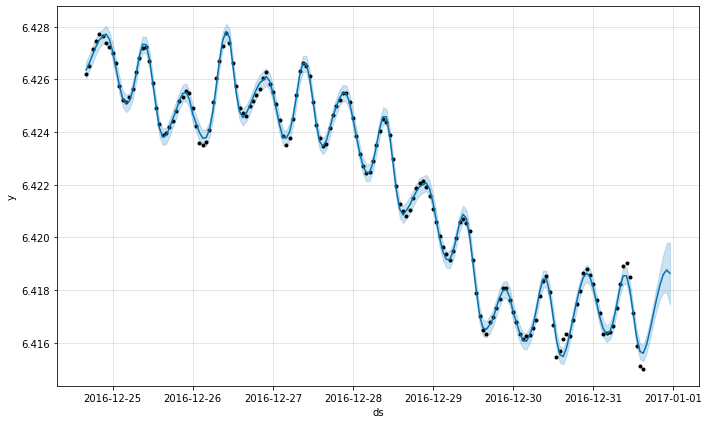

In [19]:
# Pressure forecast with a 8hr horizon
m.plot(forecast);

A time series component decomposition is avaialble. We can clearly see the daily pressure pressure variation. The trend has been a decreasing pressure over the last 7 days.

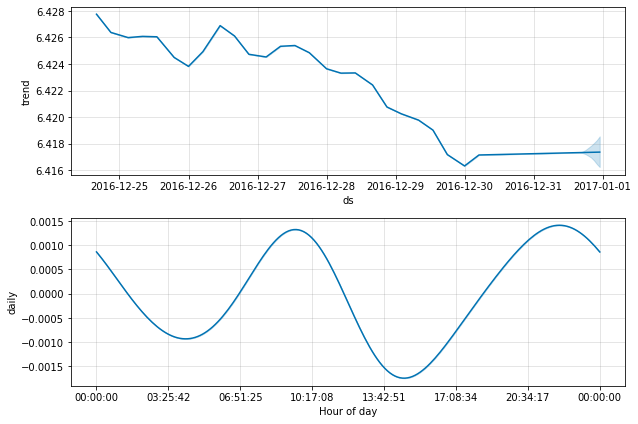

In [20]:
m.plot_components(forecast);

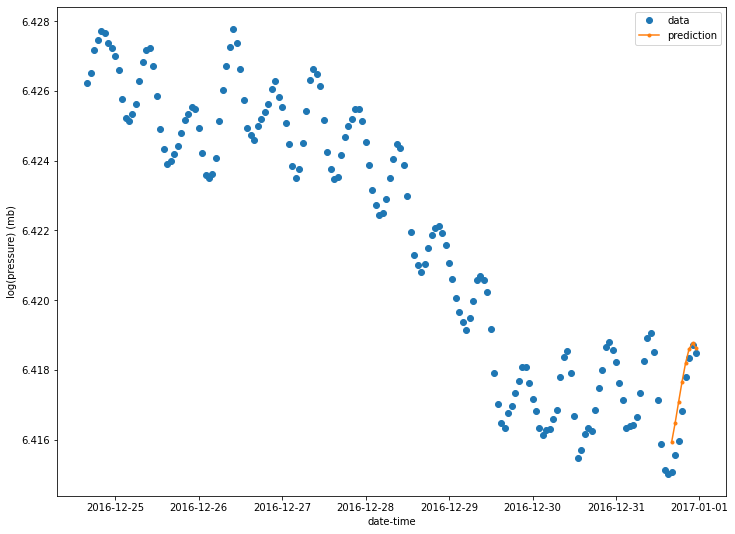

In [21]:
from matplotlib.dates import date2num
t = pressure['ds']
p = pressure['y']
dates  = date2num(t)
datesf = date2num(forecast['ds'])
plt.figure(figsize=(12,9))
plt.plot_date(dates[n1:],p[n1:],marker='o',label='data')
plt.plot_date(datesf[-horizon:],forecast['yhat'][-horizon:],
              marker='.',linestyle='-',label='prediction')
plt.legend()
plt.xlabel('date-time')
plt.ylabel('log(pressure) (mb)')
plt.show()

The 7-day window for the pressure predictions gives reasonable results. 

In [22]:
import math
# compute the mean square error
y_pred = np.array(np.exp(forecast['yhat'][-horizon:]))
y_true = np.array(np.exp(p[-horizon:]))
y_persistent = np.array(np.exp(p[n0-horizon-1:n0-1]))
mse = ((y_pred-y_true)**2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 0.18 MSE (0.42 RMSE)


A persistent model is just using the previous value as a prediction. In our case, the persistent model can predict for the next hour.

In [23]:
mse_persistent = ((y_persistent-y_true)**2).mean()
print('Persistent model quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse_persistent,
                                                                  math.sqrt(mse_persistent)))

Persistent model quality: 0.12 MSE (0.35 RMSE)


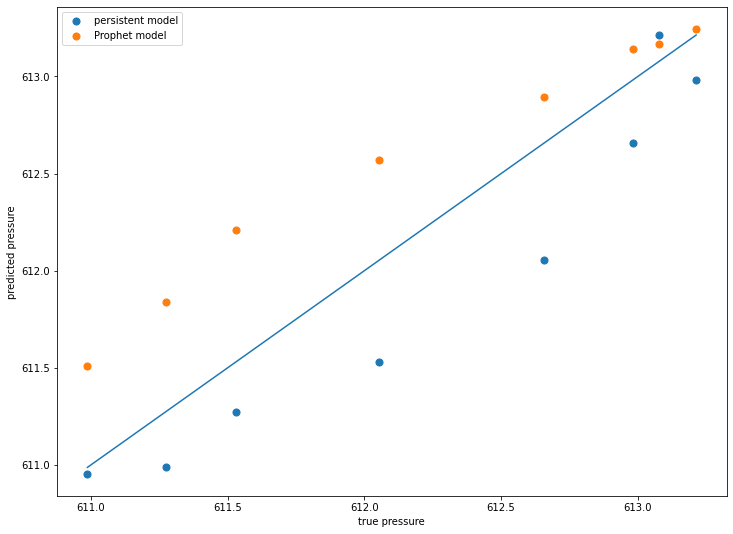

In [24]:
plt.figure(figsize=(12,9))
plt.scatter(y_true,y_persistent,label='persistent model',s=50)
plt.scatter(y_true,y_pred,label='Prophet model',s=50)
plt.plot([y_true.min(),y_true.max()],[y_true.min(),y_true.max()])
plt.xlabel('true pressure')
plt.ylabel('predicted pressure')
plt.legend()
plt.show()

An eight-hour horizon should be really a maximum before the predictions become really bad.

In this notebook, we have learnt how to:
- convert values into a pandas datetime format
- use the Facebook Prophet package to make time series predictions

One can try to predict other meteorological data as well like the temperature.